In [1]:
import glob, os, sys, toml, pickle, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from os import path

from sklearn.preprocessing import OneHotEncoder
from multiprocessing import Pool, cpu_count
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor



path_MOASMO = '/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src/'
sys.path.append(path_MOASMO)
import gp
import NSGA2


import os, sys, subprocess, time, toml

sys.path.append("/glade/u/home/mozhgana/mywork/model_calibration/src/moasmo_test/")
sys.path.append("/glade/u/home/mozhgana/mywork/model_calibration/src/moasmo_test/allbasin_emulator")
from MOASMO_parameter_allbasin_emulator import *
from multiprocessing import Pool


sys.path.append("/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src")
# import NSGA2


from MOASMO_parameters import *

import torch
import torch.nn as nn
import torch.optim as optim


import torch
import torch.nn as nn
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
infile_basin_info = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
infile_param_info = '/glade/u/home/mozhgana/mywork/model_calibration/src/moasmo_test/param_file_tpl.csv'
infile_attr_foruse = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/data/camels_attributes_table_TrainModel.csv'
inpath_moasmo = '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib'

CV=1
ncpus = 1
iterend = 1
outpathname = 'LSE_spaceCV_PredictParam_4X_ann'
suffix = f'LSEspaceCV_ann_{CV}'
objfunc = 'normKGE'
numruns = 100


In [3]:
CV=1
outpath = '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam'
# divide into train/test index
outfile = f'{outpath}/train_test_CV_indices.npz'
if os.path.isfile(outfile):
    dtmp = np.load(outfile, allow_pickle=True)
    train_indices, test_indices = dtmp['train_indices'], dtmp['test_indices']

train_index= train_indices[CV-1]
test_index= test_indices[CV-1]

In [5]:
suffix_defa_source = 'LSEnormKGE'

outpath = f"{inpath_moasmo}/{outpathname}"
os.makedirs(outpath, exist_ok=True)

# Load data: same for all iterations
df_basin_info = pd.read_csv(infile_basin_info)
df_basin_info.index = np.arange(len(df_basin_info))
all_index = np.arange(len(df_basin_info))

test_index = np.setdiff1d(all_index, train_index)

# information for all basins
df_param_info = pd.read_csv(infile_param_info)

file_defa_param = f'{outpath}/camels_summa_defa_param_train_{suffix}.csv'
df_param_defa_train = read_allbasin_defa_params(infile_param_info, file_defa_param, Basin_list, train_index)

file_defa_param = f'{outpath}/camels_summa_defa_param_test_{suffix}.csv'
df_param_defa_test = read_allbasin_defa_params(infile_param_info, file_defa_param, Basin_list, test_index)

file_param_lb = f'{outpath}/camels_summa_all_param_lb_train_{suffix}.gz'
file_param_ub = f'{outpath}/camels_summa_all_param_ub_train_{suffix}.gz'

df_param_lb_train, df_param_ub_train = load_basin_param_bounds(inpath_moasmo, df_param_defa_train, file_param_lb, file_param_ub)

file_param_lb = f'{outpath}/camels_summa_all_param_lb_test_{suffix}.gz'
file_param_ub = f'{outpath}/camels_summa_all_param_ub_test_{suffix}.gz'
df_param_lb_test, df_param_ub_test = load_basin_param_bounds(inpath_moasmo, df_param_defa_test, file_param_lb, file_param_ub)


file_camels_attribute = f'{outpath}/camels_basin_attribute_train_{suffix}.pkl'
df_att_train = read_camels_attributes(infile_basin_info, file_camels_attribute, train_index)
file_camels_attribute = f'{outpath}/camels_basin_attribute_test_{suffix}.pkl'
df_att_test = read_camels_attributes(infile_basin_info, file_camels_attribute, test_index)

df_att_foruse = pd.read_csv(infile_attr_foruse)
useattrs = list(df_att_foruse[df_att_foruse['att_Xie2021'].values]['Attribute_text'].values)
print("The number of attributes used:", len(useattrs))
print(useattrs)


suffixtest = suffix+'test'

# Load data: outputs from each iteration from training basins
for iter in range(0, iterend):
    file_all_param = f'{outpath}/camels_summa_all_param_train_{suffix}_iter{iter}.gz'
    file_all_metric = f'{outpath}/camels_summa_all_metric_train_{suffix}_iter{iter}.gz'
    file_all_basinid = f'{outpath}/camels_summa_all_basinid_train_{suffix}_iter{iter}.gz'

    file_all_param_test = f'{outpath}/camels_summa_all_param_test_{suffix}_iter{iter}.gz'
    file_all_metric_test = f'{outpath}/camels_summa_all_metric_test_{suffix}_iter{iter}.gz'
    file_all_basinid_test = f'{outpath}/camels_summa_all_basinid_test_{suffix}_iter{iter}.gz'

    if iter == 0:

        df_param_i, df_metric_i, df_basinid_i = load_all_basin_params_metrics(inpath_moasmo, infile_param_info, df_param_defa_train,
                                                                              df_basin_info, iter, file_all_param,
                                                                              file_all_metric, file_all_basinid,
                                                                              train_index, suffix_defa_source)
    
        df_param_i_test, df_metric_i_test, df_basinid_i_test = load_all_basin_params_metrics(inpath_moasmo, infile_param_info, df_param_defa_test,
                                                                              df_basin_info, iter, file_all_param_test,
                                                                              file_all_metric_test, file_all_basinid_test,
                                                                              test_index, suffix_defa_source)
    else:
        df_param_i, df_metric_i, df_basinid_i = load_all_basin_params_metrics(inpath_moasmo, infile_param_info, df_param_defa_train,
                                                                              df_basin_info, iter, file_all_param,
                                                                              file_all_metric, file_all_basinid,
                                                                              train_index, suffix)
    
        df_param_i_test, df_metric_i_test, df_basinid_i_test = load_all_basin_params_metrics(inpath_moasmo, infile_param_info, df_param_defa_test,
                                                                              df_basin_info, iter, file_all_param_test,
                                                                              file_all_metric_test, file_all_basinid_test,
                                                                              test_index, suffixtest)

    df_basinid_i['iter'] = iter
    df_basinid_i_test['iter'] = iter

    if iter == 0:
        df_param = df_param_i
        df_metric = df_metric_i
        df_basinid = df_basinid_i
        
        df_param_test = df_param_i_test
        df_metric_test = df_metric_i_test
        df_basinid_test = df_basinid_i_test
    else:
        df_param = pd.concat([df_param, df_param_i])
        df_metric = pd.concat([df_metric, df_metric_i])
        df_basinid = pd.concat([df_basinid, df_basinid_i])
        
        df_param_test = pd.concat([df_param_test, df_param_i_test])
        df_metric_test = pd.concat([df_metric_test, df_metric_i_test])        
        df_basinid_test = pd.concat([df_basinid_test, df_basinid_i_test])

df_param = df_param.apply(pd.to_numeric, errors='coerce')
df_param_test = df_param_test.apply(pd.to_numeric, errors='coerce')


df_param.index = np.arange(len(df_param))
df_metric.index = np.arange(len(df_metric))
df_basinid.index = np.arange(len(df_basinid))

df_param_test.index = np.arange(len(df_param_test))
df_metric_test.index = np.arange(len(df_metric_test))
df_basinid_test.index = np.arange(len(df_basinid_test))


index = np.isnan(np.sum(df_metric.values, axis=1) + np.sum(df_param.values, axis=1))
df_param = df_param[~index]
df_metric = df_metric[~index]
df_basinid = df_basinid[~index]

index_test = np.isnan(np.sum(df_metric_test.values, axis=1) + np.sum(df_param_test.values, axis=1))
df_param_test = df_param_test[~index_test]
df_metric_test = df_metric_test[~index_test]
df_basinid_test = df_basinid_test[~index_test]


df_param.index = np.arange(len(df_param))
df_metric.index = np.arange(len(df_metric))
df_basinid.index = np.arange(len(df_basinid))

df_param_test.index = np.arange(len(df_param_test))
df_metric_test.index = np.arange(len(df_metric_test))
df_basinid_test.index = np.arange(len(df_basinid_test))


print('Number of nan samples:', np.sum(index))
print("Number of original parameter sets:", len(index))
print("Number of final parameter sets:", len(df_param))


# One-hot encoding for categorical attributes
df_att = pd.concat([df_att_train, df_att_test])
df_att.index = np.arange(len(df_att))
df_att_use = df_att[useattrs + ["hru_id"]]

for att in useattrs:
    if df_att_use[att].dtype == "object":
        print('Convert', att, 'to one-hot encoding')
        enc = OneHotEncoder(sparse_output=False)
        enc.fit(df_att_use[[att]])
        encnames = [att + "_" + str(i) for i in range(len(enc.categories_[0]))]
        print('New columns:', encnames)
        df_enc = pd.DataFrame(enc.transform(df_att_use[[att]]), columns=encnames)
        df_att_use = pd.concat([df_att_use, df_enc], axis=1)
        df_att_use = df_att_use.drop([att], axis=1)

df_att_use_train = df_att_use[:len(df_att_train)]
df_att_use_test = df_att_use[len(df_att_train):]
df_att_use_train.index = np.arange(len(df_att_use_train))
df_att_use_test.index = np.arange(len(df_att_use_test))

useattrs = list(df_att_use_train.columns)
useattrs.remove('hru_id')

# Prepare model input and output
df_input = df_param.copy()
df_input["hru_id"] = df_basinid["basin_name"]
df_input = df_input.merge(df_att_use_train[useattrs + ["hru_id"]], on="hru_id", how="left")
df_input = df_input.drop(["hru_id"], axis=1)

inputnames = list(df_param.columns) + useattrs
x_all = df_input[inputnames].values.copy()
print("Input shape:", x_all.shape)

print('Train/test model')
print('Train index:', train_index)

# divide samples into training and validation sets (70% vs 30%)
hru_idu = np.unique(df_basinid["basin_name"].values)
index_val_tmp = np.linspace(0, len(hru_idu)-1, int(len(hru_idu) * 0.3 )).astype(int)
index_train_tmp = np.setdiff1d(np.arange(len(hru_idu)), index_val_tmp)
hru_idu_train = hru_idu[index_train_tmp]
hru_idu_val = hru_idu[index_val_tmp]

index_train = df_basinid["basin_name"].isin(hru_idu_train)
index_val = df_basinid["basin_name"].isin(hru_idu_val)

x_train, x_val = x_all[index_train, :], x_all[index_val, :]

# Normalize the features
x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - x_train_mean) / x_train_std
x_val_scaled = (x_val - x_train_mean) / x_train_std


if objfunc == 'normKGE':
    print('Use normalized KGE as output')
    df_output = df_metric.copy()
    y_all = df_output[["kge"]].values.copy()
    y_all = y_all / (2 - y_all)  # Normalize KGE
    y_train, y_val = y_all[index_train], y_all[index_val]
    



File exists: /glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X_ann/camels_basin_attribute_train_LSEspaceCV_ann_1.pkl
File exists: /glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X_ann/camels_basin_attribute_test_LSEspaceCV_ann_1.pkl
The number of attributes used: 27
['mean_elev', 'mean_slope', 'area_gauges2', 'p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur', 'frac_forest', 'lai_max', 'lai_diff', 'dom_land_cover', 'dom_land_cover_frac', 'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 'carbonate_rocks_frac', 'geol_permeability']
Number of nan samples: 406
Number of original parameter sets: 200400
Number of final parameter sets: 199994
Convert dom_land_cover to one-hot encoding
New columns: ['dom_land_cover_0', 'dom_land_cover_1', 'dom_la

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim


# Define the neural network model outside the function
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

    # Add a predict method similar to sklearn's
    def predict(self, X):
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32)

        self.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            predictions = self.forward(X)
        return predictions.numpy()  # Convert the predictions back to numpy


def train_nn_model_pytorch(x_train_scaled, y_train, x_val_scaled, y_val, n_epochs=1000, patience=10, lr=0.001, model_file="model.pth"):

    # # Check if model file exists, and load the model if it does
    # if os.path.isfile(model_file):
    #     print(f"Loading model from {model_file}")
    #     model = SimpleNN(input_size=x_train_scaled.shape[1])
    #     model.load_state_dict(torch.load(model_file))
    #     return model

    # Convert data to PyTorch tensors
    x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

    # Initialize the model, loss function, and optimizer
    model = SimpleNN(input_size=x_train_tensor.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Early stopping parameters
    best_loss = float('inf')
    patience_counter = 0

    # Training loop
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        predictions = model(x_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_predictions = model(x_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor)

        print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

        # Early stopping logic
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            patience_counter = 0
            # torch.save(model.state_dict(), model_file)  # Save the best model
            print(f"Model saved to {model_file}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping triggered.')
            break

    # Load the best model state before returning
    # model.load_state_dict(torch.load(model_file))

    # Return the trained model, now with predict method
    return model

In [ ]:
        df_output = df_metric.copy()
        y_all = df_output[["kge"]].values.copy()
        y_all = y_all / (2 - y_all)  # Normalize KGE
        y_train, y_val = y_all[index_train], y_all[index_val]
        
        # Train a random forest emulator
        outfile = f'{outpath}/ANN_emulator_for_iter{iterend}_{suffix}'
        em_model = train_nn_model_pytorch(x_train_scaled, y_train, x_val_scaled, y_val, model_file=outfile)


/glade/work/guoqiang/conda-envs/PytorchEnv/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([139994, 1, 1])) that is different to the input size (torch.Size([139994, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/glade/work/guoqiang/conda-envs/PytorchEnv/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([60000, 1, 1])) that is different to the input size (torch.Size([60000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Training Loss: 0.1524234414100647, Validation Loss: 0.14385977387428284
Model saved to /glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X_ann/ANN_emulator_for_iter1_LSEspaceCV_ann_1
Epoch 2, Training Loss: 0.1359906643629074, Validation Loss: 0.1347760111093521
Model saved to /glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X_ann/ANN_emulator_for_iter1_LSEspaceCV_ann_1
Epoch 3, Training Loss: 0.12794014811515808, Validation Loss: 0.13036052882671356
Model saved to /glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X_ann/ANN_emulator_for_iter1_LSEspaceCV_ann_1
Epoch 4, Training Loss: 0.1237681433558464, Validation Loss: 0.12729157507419586
Model saved to /glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X_ann/ANN_emulator_for_iter1_LSEspaceCV_ann_1


ANN Emulator - MSE: 0.023963034572959934 R^2: 0.7702877269630366
RF Emulator - MSE: 0.22036695768429718 R^2: -1.1124617834930364


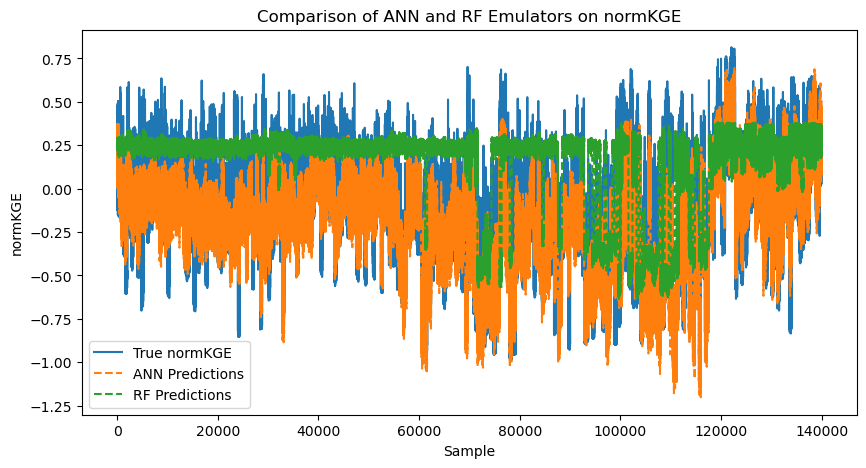

In [6]:
import torch
import torch.nn as nn
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load preprocessed input features (x_train_scaled) and target values (y_train) for training


# Define paths to saved models
ann_path = '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X_ann/ANN_emulator_for_iter1_LSEspaceCV_ann_1'
rf_path = '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X/RF_emulator_for_iter1_LSEspaceCV_1.pkl'

# Define the ANN model class
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Load ANN emulator
ann_model = SimpleNN(input_size=x_train_scaled.shape[1])
ann_model.load_state_dict(torch.load(ann_path))

# Load RF emulator
rf_model = joblib.load(rf_path)

# Convert input features to tensor for ANN model
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)

# Make predictions with ANN emulator
ann_model.eval()
with torch.no_grad():
    ann_predictions = ann_model(x_train_tensor).numpy().flatten()

# Make predictions with RF emulator
rf_predictions = rf_model.predict(x_train_scaled)

# Evaluate accuracy of each model
ann_mse = mean_squared_error(y_train, ann_predictions)
rf_mse = mean_squared_error(y_train, rf_predictions)
ann_r2 = r2_score(y_train, ann_predictions)
rf_r2 = r2_score(y_train, rf_predictions)

print("ANN Emulator - MSE:", ann_mse, "R^2:", ann_r2)
print("RF Emulator - MSE:", rf_mse, "R^2:", rf_r2)

# Visual comparison of predictions
plt.figure(figsize=(10, 5))
plt.plot(y_train, label='True normKGE')
plt.plot(ann_predictions, label='ANN Predictions', linestyle='--')
plt.plot(rf_predictions, label='RF Predictions', linestyle='--')
plt.xlabel("Sample")
plt.ylabel("normKGE")
plt.legend()
plt.title("Comparison of ANN and RF Emulators on normKGE")
plt.show()
